# Introduction to Neural Networks

Three components are necessary to train a neural network:
1. neural network architecture
2. loss function
3. optimization algorithm

All these components can be easily implemented using one of the deep learning libraries for Python, e.g. PyTorch, TensorFlow, or JAX. You can find also some higher-level libraries built on top of these low-level libraries, e.g. Kera or Sonnet for TensorFlow or Haiku for JAX. We will be using PyTorch and PyTorch-Geometric to build graph neural networks.


## Neural network architecture: model capacity and inductive bias

Neural networks usually consist of layers, i.e. a network is a sequence of neural layers that transform the input representation. The most basic layer in neural networks is probably a **linear** or **fully-connected layer**. All input features are connected to all layer output features (neurons), and the strength of these connections is learned when the network is trained. Mathematically, we can write:

$$
[x_1, \dots, x_n] \cdot \begin{bmatrix} 
w_{11} & \cdots & w_{1m} \\
\vdots & \ddots & \vdots \\
w_{n1} & \cdots & w_{nm}
\end{bmatrix} = \mathbf{x}^T W = \mathbf{y}^T =[y_1, \dots, y_m],
$$

where $\mathbf{x}\in\mathbb{R}^n$ is the layer input, and $\mathbf{y}\in\mathbb{R}^m$ is the layer output. 
$W\in\mathbb{R}^{n\times m}$ are layer parameters called **weights**. Usually a **bias** term is added to the transformed output, i.e. $\mathbf{x}^T W + \mathbf{b}^T$. Let's note that single output neurons follow the equation similar to linear regression:

$$
y_k = x_1 w_{1k} + x_2 w_{2k} + \cdots + x_n w_{nk} + b_k
$$

Another important class of layers are **non-linear layers** (or **activation layers**). They usually don't contain trainable parameters and are used only to introduce non-linearity to the model. Without them, only linear depenencies could be learned, so the network wouldn't be able to learn anything more than a simple linear regression. Currently, the most widely used activation is **ReLU** (Rectified Linear Unit) because of its effectiveness in terms of the computational cost and training outcomes. The ReLU layer is defined as:

$$
ReLU(x) = \max(x,0) = \begin{cases} x & \text{dla } x \geq 0,\\ 0 & \text{dla } x < 0. \end{cases}
$$

Another important type of non-linearity is **sigmoid**, which is less effective computation-wise. Sigmoid was used also in the logistic regression for binary classification. It returns numbers in the range (0, 1), which can be treated as positive class probabilities.

$$
\sigma(x) = \frac{1}{1+e^{-x}}
$$

## Loss function: problem definition and optimization target

The neural architecture defines the transformations that the network is capable of performing, but it doesn't define the training task itself. To determine what our network should learn, we will need a **loss function**, which is an optimization target. It's a function that will me minimized (rarely maximized) by modifying network parameters (weights).

For example, for the regression problem, a standard loss function is the mean squared error (MSE) that measures the average error of all predictions, squared:

$$
\mathcal{L}(\mathcal{X}|\Theta)=\mathrm{MSE}(\mathcal{X}|\Theta) = \frac{1}{|\mathcal{X}|} \sum_{i=1}^{|\mathcal{X}|} e_i^2 = \frac{1}{|\mathcal{X}|} \sum_{i=1}^{|\mathcal{X}|} (y_i - \hat{y}_i)^2 = \frac{1}{|\mathcal{X}|} \sum_{i=1}^{|\mathcal{X}|} (y_i - f(\mathbf{x}_i|\Theta))^2
$$ 

We'll be minimizing this function with respect to the parameters $\Theta$, which are network weights.

$$
\Theta^* = {\arg \min}_\Theta \,\, \mathcal{L}(\mathcal{X}|\Theta)
$$

## Optimization algorithm: method to reach the minimum of the loss function

Having defined the architecture and loss function, we need to choose an algorithm that will find optimal model parameters. In the classical machine learning, we oftentimes analytically derived the formulas to find optimal parameters. The diversity and complexity of neural networks make it infeasible to find such solutions for these models.

However, we can use **gradient optimization** methods, which compute the loss function gradients (derivatives) w.r.t. the model parameters and move these parameters towards the direction opposite to the gradient (if our goal is to minimize the loss function). It is possible because of the differentiability of all operations in a neural network and the **chain rule**.

The most standard algorithm is **SGD** (Stochastic Gradient Descent):

$$
\Theta \leftarrow \Theta - \eta \nabla \mathcal{L}(\mathcal{X}|\Theta),
$$

where $\eta$ is learning rate, which can be selected for a specific task (it's a hyperparameter). The SGD method is the most basic, and many follow-up methods have been implemented in deep learning libraries. For example, **Momentum** is a technique that accumulates past gradients to accelerate the convergence and to avoid local minima.

$$
v \leftarrow \gamma v + \eta \nabla \mathcal{L}(\mathcal{X}|\Theta), \\
\Theta \leftarrow \Theta - v.
$$

The momentum constant $\gamma$ is usually set to 0.9 (it should be less than 1 to gradually decrease the momentum).

**Exercise 1:** Fill in the neural network training code by implementing the three training components mentioned above. This code uses Morgan fingerprints (ECFP) to predict the compound solubility.

In [1]:
import pandas as pd
import numpy as np
import torch
from tdc.single_pred.adme import ADME
from tdc import Evaluator
from tqdm.notebook import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader
from rdkit import Chem
from rdkit.Chem import AllChem
from matplotlib import pyplot as plt
from IPython import display

from typing import List, Tuple


class Featurizer:
    def __init__(self, y_column, smiles_col='Drug', **kwargs):
        self.y_column = y_column
        self.smiles_col = smiles_col
        self.__dict__.update(kwargs)
    
    def __call__(self, df):
        raise NotImplementedError()


class ECFPFeaturizer(Featurizer):
    def __init__(self, y_column, radius=2, length=1024, **kwargs):
        self.radius = radius
        self.length = length
        super().__init__(y_column, **kwargs)
    
    def __call__(self, df):
        fingerprints = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row[self.smiles_col]
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.length)
            fingerprints.append(fp)
            labels.append(y)
        fingerprints = np.array(fingerprints)
        labels = np.array(labels)
        return fingerprints, labels

data = ADME('Solubility_AqSolDB')
split = data.get_split()
rmse = Evaluator(name = 'RMSE')

featurizer = ECFPFeaturizer(y_column='Y')
X_train, y_train = featurizer(split['train'])
X_valid, y_valid = featurizer(split['valid'])
X_test, y_test = featurizer(split['test'])

Found local copy...
Loading...
Done!
[16:42:19] WARNING: not removing hydrogen atom without neighbors
[16:42:19] WARNING: not removing hydrogen atom without neighbors
[16:42:19] WARNING: not removing hydrogen atom without neighbors
[16:42:19] WARNING: not removing hydrogen atom without neighbors
[16:42:19] WARNING: not removing hydrogen atom without neighbors
[16:42:19] WARNING: not removing hydrogen atom without neighbors
[16:42:19] WARNING: not removing hydrogen atom without neighbors
[16:42:19] WARNING: not removing hydrogen atom without neighbors
[16:42:19] WARNING: not removing hydrogen atom without neighbors
[16:42:19] WARNING: not removing hydrogen atom without neighbors
[16:42:19] WARNING: not removing hydrogen atom without neighbors
[16:42:19] WARNING: not removing hydrogen atom without neighbors
[16:42:19] WARNING: not removing hydrogen atom without neighbors
[16:42:19] WARNING: not removing hydrogen atom without neighbors
[16:42:19] WARNING: not removing hydrogen atom withou

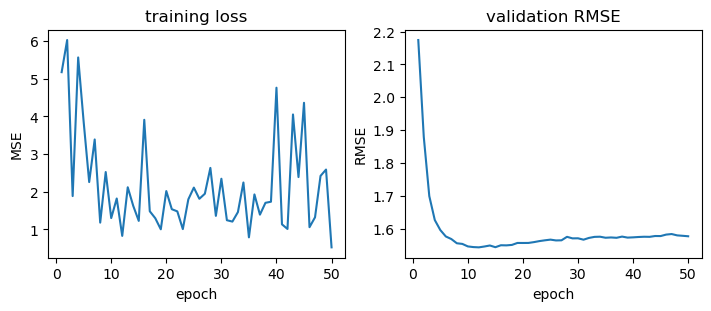

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

RMSE = 1.543
Looks OK!


In [2]:
def train(X_train, y_train, X_valid, y_valid):
    # hyperparameters definition
    hidden_size = 512
    epochs = 50
    batch_size = 64
    learning_rate = 0.0001
    
    # model preparation
    model = torch.nn.Sequential(
        torch.nn.Linear(hidden_size*2, hidden_size),
        torch.nn.Linear(hidden_size, 1)
    )  # TODO: define a simple neural network, you can use torch.nn.Sequential
    
    # data preparation
    dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train.reshape(-1, 1)))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    valid_dataset = TensorDataset(torch.FloatTensor(X_valid), torch.FloatTensor(y_valid.reshape(-1, 1)))
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    
    # prepare metrics plots
    fig, ax = plt.subplots(ncols=2, figsize=(7, 3), layout="constrained")
    dh = display.display(fig, display_id=True)
    df_metrics = pd.DataFrame(columns=["epoch","loss","rmse"])
    
    # training loop
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)  # TODO: define an optimizer
    loss_fn = torch.nn.MSELoss()  # TODO: define a loss function
    for epoch in trange(1, epochs + 1, leave=False):
        model.train()
        for X, y in tqdm(loader, leave=False):
            model.zero_grad()
            preds = model(X)
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()
        
        # validation loop
        model.eval()
        preds_batches = []
        with torch.no_grad():
            for X, y in tqdm(valid_loader, leave=False):
                preds = model(X)
                preds_batches.append(preds.cpu().detach().numpy())
        preds = np.concatenate(preds_batches)
        rmse_score = rmse(y_valid, preds)
        
        df_metrics.loc[len(df_metrics)] = {'epoch': epoch, 'loss': loss.item(), 'rmse': rmse_score}
        ax[0].clear()
        ax[0].plot(df_metrics.epoch, df_metrics.loss)
        ax[0].set_title('training loss')
        ax[0].set_xlabel('epoch')
        ax[0].set_ylabel('MSE')
        ax[1].clear()
        ax[1].plot(df_metrics.epoch, df_metrics.rmse)
        ax[1].set_title('validation RMSE')
        ax[1].set_xlabel('epoch')
        ax[1].set_ylabel('RMSE')
        dh.update(fig)
    plt.close()
    return model


def predict(model, X_test, y_test):
    # hyperparameters definition
    # (but this doesn't change the training results, it's only to optimize the eval speed)
    batch_size = 64

    # data preparation
    dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test.reshape(-1, 1)))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # evaluation loop
    preds_batches = []
    with torch.no_grad():
        for X, y in tqdm(loader):
            preds = model(X)
            preds_batches.append(preds.cpu().detach().numpy())
    preds = np.concatenate(preds_batches)
    return preds

# training
model = train(X_train, y_train, X_valid, y_valid)

# evaluation
predictions = predict(model, X_test, y_test)

rmse_score = rmse(y_test, predictions)
print(f'RMSE = {rmse_score:.3f}')
assert rmse_score < 1.6, "It should be possible to obtain RMSE lower than 1.6"
print('Looks OK!')

# Molecular graphs

**Recap:** In mathematics, a graph is an object that consists of a set of vertices (nodes) connected with edges, i.e. $\mathcal{G} = (V, E)$, where $V = \{ v_i: i \in \{1, 2, \dots, N \} \}$ and $E \subseteq \{ (v_i, v_j):\, v_i,v_j \in V \}$.

Molecular graphs are a special class of graphs, where besides nodes (denoting atoms) and edges (denoting chemical bonds), we have an additional information about atom types and sometimes also bond types. We can assume that we have an additional set of node/atom features encoded as a matrix $X$, where $X_{ij}$ is the $j$-th feature of the $i$-th atom. As atomic features, we can have one-hot encoded atom symbols (a vector containing zeros on all positions besides the position that corresponds to the atom symbol), the number of implicit hydrogens bonded with this atom, or the number of heavy neighbors (atoms other than hydrogens bonded to the given atom).

Egdes/bonds can be encoded in two different ways. One method is to use an adjacency matrix $A$, where $A_{ij}=1$ if nodes/atoms $v_i$ nad $v_j$ are connected ($A_{ij}=0$ otherwise). In the case of sparse matrices, a more useful encoding is a list of pairs of connected atoms (a list of index pairs). This latter enocding is used by the PyTorch-Geometric library.

In practice, a molecular graph can be described by two matrices: $X \in \mathbb{R}^{N \times F}$ and $E \in \{0, 1,\dots,N-1\}^{2 \times N}$, where $N$ is the number of atoms, and $F$ is the number of atomic features.

![molecular graph](../../lectures/assets/mol_graph.png)

**Exercise 2:** Create a molecular graph dataset using PyTorch-Geometric and the same data as in Exercise 1.

In [8]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader


def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise ValueError("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


from rdkit.Chem import rdMolDescriptors

class GraphFeaturizer(Featurizer):
    def __call__(self, df):
        graphs = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row[self.smiles_col]
            mol = Chem.MolFromSmiles(smiles)
            
            edges = []
            for bond in mol.GetBonds():
                begin = bond.GetBeginAtomIdx()
                end = bond.GetEndAtomIdx()
                edges.append((begin, end))  # TODO: Add edges in both directions
            edges = np.array(edges)
            
            nodes = []
            for atom in mol.GetAtoms():
                # print(atom.GetAtomicNum(), atom.GetNumImplicitHs(), atom.GetTotalNumHs(), atom.GetSymbol(), atom.GetNumExplicitHs(), atom.GetTotalValence())
                results = one_of_k_encoding_unk(atom.GetAtomicNum(), range(11)) + one_of_k_encoding(
                    atom.GetDegree(), range(11)
                ) + one_of_k_encoding_unk(
                    atom.GetImplicitValence(), range(11)
                ) + [atom.GetIsAromatic()] + one_of_k_encoding_unk(
                    atom.GetTotalNumHs(), range(11)
                ) + [atom.GetNumImplicitHs(), atom.GetFormalCharge(), atom.GetNumRadicalElectrons(), atom.GetIsAromatic()] # TODO: Add atom features as a list, you can use one_of_k_encodings defined above
                # print(results)
                nodes.append(results)
            nodes = np.array(nodes)
            
            graphs.append((nodes, edges.T))
            labels.append(y)
        labels = np.array(labels)
        return [Data(
            x=torch.FloatTensor(x), 
            edge_index=torch.LongTensor(edge_index), 
            y=torch.FloatTensor([y])
        ) for ((x, edge_index), y) in zip(graphs, labels)]

In [9]:
featurizer = GraphFeaturizer('Y')
graph = featurizer(split['test'].iloc[:1])[0]

assert graph.x.ndim == 2, 'The atom features should be a matrix with dimensions (number of atoms) x (number of features)'
assert graph.edge_index.ndim == 2, 'The edges should be represented as a matrix of atom pairs'
assert graph.edge_index.shape[0] == 2, 'The first dimension should be 2 (we need atom pairs)'
assert isinstance(graph.y, torch.FloatTensor) and graph.y.shape == (1,), 'The graph label should be assigned to the variable `y`'
print('Looks OK!')

Looks OK!


# Graph neural networks

Graph neural networks (GNNs) can process graph representation given at the input to the model. A graph layer uses the input atom features and graph topology to calculate new atom representations, but the graph structure is not changed (the edges stay the same). We can use the calculated atom representations for **node classification**, or we can add a graph readout operation at the end to aggregate information from all nodes into one vector that describes the whole graph (e.g. we can use the average atom representation). The graph representation can be then processed by fully-connected layers for the **graph classification** task.


## Message Passing Neural Networks (MPNN)

MPNN is a general description of a graph neural network, and many graph neural network architectures can be matched with this description (including the ones listed below). In MPNN, **messages** $M$ from the neighboring atoms are retrieved to calculate a new atom representation via the **update** $U$ operation. This procedure is repeated a few times before we use **readout** $R$ to compute the graph representation.

$$
\mathbf{m}_i^{t+1} = \sum_{j\in\mathcal{N}(i)} M_t(\mathbf{h}_i^t, \mathbf{h}_j^t, \mathbf{e}_{ij})\\
\mathbf{h}_i^{t+1} = U_t(\mathbf{h}_i^t, \mathbf{m}_i^{t+1}) \\
\hat{y} = R(\{\mathbf{h}_i^T \, | \, i \in \mathcal{G} \})
$$

- **Graph Convolutional Networks (GCN)**

$$
\mathbf{h}_i^{t+1} = W^T \sum_{j\in\mathcal{N}(i)\cup \{i\}} \frac{e_{ij}}{\sqrt{\hat{d}_i \hat{d}_j}} \mathbf{h}_j^t
$$

- **Graph Isomorphism Networks (GIN)**

$$
\mathbf{h}_i^{t+1} = W^T \left( (1+\varepsilon)\mathbf{h}_i^t + \sum_{j\in\mathcal{N}(i)} \mathbf{h}_j^t \right)
$$

- **GraphSAGE**

$$
\mathbf{h}_i^{t+1} = W_1 \mathbf{h}_i^t + W_2 \frac{1}{|\mathcal{N}(i)|} \sum_{j\in\mathcal{N}(i)} \mathbf{h}_j^t
$$

- **Graph Attention Networks (GAT)**

$$
\mathbf{h}_i^{t+1} = \sum_{j\in\mathcal{N}(i)\cup \{i\}} \alpha_{ij} W \mathbf{h}_j^t,\\
\alpha_{ij} = \frac{\exp\left( LeakyReLU(\mathbf{a}[W\mathbf{h}_i^t \| W\mathbf{h}_j^t])\right)}{\sum_{k\in\mathcal{N}(i) \cup \{i\}}\exp\left( LeakyReLU(\mathbf{a}[W\mathbf{h}_i^t \| W\mathbf{h}_k^t])\right)}
$$

**Exercise 3:** Use the molecular graphs prepared in the previous exercise to predict compound solubility.

In [10]:
from torch_geometric.loader import DataLoader as GraphDataLoader


# prepare data loaders
batch_size = 64
train_loader = GraphDataLoader(featurizer(split['train']), batch_size=batch_size, shuffle=True)
valid_loader = GraphDataLoader(featurizer(split['valid']), batch_size=batch_size)
test_loader = GraphDataLoader(featurizer(split['test']), batch_size=batch_size)

[16:52:45] WARNING: not removing hydrogen atom without neighbors
[16:52:45] WARNING: not removing hydrogen atom without neighbors
[16:52:45] WARNING: not removing hydrogen atom without neighbors
[16:52:45] WARNING: not removing hydrogen atom without neighbors
[16:52:45] WARNING: not removing hydrogen atom without neighbors
[16:52:46] WARNING: not removing hydrogen atom without neighbors
[16:52:46] WARNING: not removing hydrogen atom without neighbors
[16:52:46] WARNING: not removing hydrogen atom without neighbors
[16:52:46] WARNING: not removing hydrogen atom without neighbors
[16:52:46] WARNING: not removing hydrogen atom without neighbors
[16:52:46] WARNING: not removing hydrogen atom without neighbors
[16:52:46] WARNING: not removing hydrogen atom without neighbors
[16:52:46] WARNING: not removing hydrogen atom without neighbors
[16:52:46] WARNING: not removing hydrogen atom without neighbors
[16:52:46] WARNING: not removing hydrogen atom without neighbors
[16:52:46] WARNING: not r

In [15]:
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool as gap


class GraphNeuralNetwork(torch.nn.Module):  # TODO: assign hyperparameters to attributes and define the forward pass
    def __init__(self, hidden_size, n_features=49, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(n_features, hidden_size)
        self.conv2 = GCNConv(hidden_size, int(hidden_size/2))
        self.conv3 = GCNConv(int(hidden_size/2), int(hidden_size/4))
        self.linear = torch.nn.Linear(int(hidden_size/4), 1)
        self.dropout = dropout
    
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        
        x = gap(x, batch)
        
        x = F.dropout(x, p=self.dropout, training=self.training)

        out = self.linear(x)

        return out

In [20]:
def train(train_loader, valid_loader):
    # hyperparameters definition
    hidden_size = 512
    epochs = 120
    learning_rate = 0.001
    
    # model preparation
    model = GraphNeuralNetwork(hidden_size)  # TODO: you can add more hyperparameters if needed
    model.train()
    
    # training loop
    optimizer = torch.optim.Adam(model.parameters(), learning_rate) # TODO: define an optimizer
    loss_fn = torch.nn.MSELoss()  # TODO: define a loss function
    for epoch in trange(1, epochs + 1, leave=False):
        for data in tqdm(train_loader, leave=False):
            x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
            model.zero_grad()
            preds = model(x, edge_index, batch)
            loss = loss_fn(preds, y.reshape(-1, 1))
            loss.backward()
            optimizer.step()
    return model


def predict(model, test_loader):
    # evaluation loop
    preds_batches = []
    with torch.no_grad():
        for data in tqdm(test_loader):
            x, edge_index, batch = data.x, data.edge_index, data.batch
            
            preds = model(x, edge_index, batch)
            preds_batches.append(preds.cpu().detach().numpy())
    preds = np.concatenate(preds_batches)
    return preds


# training
model = train(train_loader, valid_loader)

# evaluation
predictions = predict(model, test_loader)

rmse_score = rmse(y_test, predictions.flatten())

print(f'RMSE = {rmse_score:.2f}')
assert rmse_score < 1.4, "It should be possible to obtain RMSE lower than 1.4"
print('Looks OK!')

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

RMSE = 1.38
Looks OK!


# Explainability of GNN predictions: Grad-CAM

In many applications of machine learning, it is crucial to understand model predictions. For example, it is important to understand why our model predicted toxicity if we want to improve the chemical structure and get rid of this liability. In graph neural networks, we can create an importance map overlayed on top of the chemical structure to point at the atoms important for the prediction.

Grad-CAM is an explainability method developed for convolutional neural networks (images), and can be adapted to graph convolutions. The representation after the last graph layer is called an **activation map** $F$, where $F_{i,j}$ represents the $i$-th feature of the $j$-th atom. To find out which atomic features correlate with the prediction, we can compute gradients of the predicted class probability w.r.t. the activation map features. Next, these gradients $\alpha$ are multiplied by the values in the activation maps to calculate per-atom importances.

$$
\alpha_k^{l,c}=\frac{1}{N}\sum_{n=1}^N \frac{\partial y^c}{\partial F_{k,n}^l},\\
L^c(l,n) = ReLU\left(\sum_k \alpha_k^{l,c} F_{k,n}^l (X, A)\right)
$$

**(optional) Exercise 4.** Copy the graph network code from the previous exercise into correct places, train this modified network, and complete the Grad-CAM code to see the prediction explanations.

In [ ]:
class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        ...  # TODO: copy from Exercise 3
    
    def activations_hook(self, grad):
        self.final_conv_grads = grad
    
    def forward(self, x, edge_index, batch):
        ...  # TODO: copy from Exercise 3
        with torch.enable_grad():
            self.final_conv_acts = ...  # TODO: assign convolution activations here
        self.final_conv_acts.register_hook(self.activations_hook)
        ...  # TODO: copy from Exercise 3
        return ...  # TODO: copy from Exercise 3

In [ ]:
# TODO: train this network using the script in Exercise 3.

In [124]:
import torch.nn.functional as F


def grad_cam(final_conv_acts, final_conv_grads):
    node_heat_map = []
    alphas = ...  # TODO (formula 1)
    for n in range(final_conv_acts.shape[0]): # nth node
        node_heat = ...  # TODO (formula 2)
        node_heat_map.append(node_heat)
    return node_heat_map

In [5]:
test_set = featurizer(split['test'])

In [6]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

import matplotlib
import matplotlib.cm as cm


compound_idx = 110
mol = Chem.MolFromSmiles(split['test'].iloc[compound_idx].Drug)

data = test_set[compound_idx]
x, edge_index, batch = data.x, data.edge_index, data.batch

model(x, edge_index, torch.zeros(x.shape[0], dtype=torch.int64))
atom_weights = grad_cam(model.final_conv_acts, model.final_conv_grads)

atom_weights = np.array(atom_weights)
if (atom_weights > 0.).any():
    atom_weights = atom_weights / atom_weights.max() / 2

if len(atom_weights) > 0:
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    cmap = cm.get_cmap('bwr')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {
        i: plt_colors.to_rgba(atom_weights[i]) for i in range(len(atom_weights))
    }
    highlight_kwargs = {
        'highlightAtoms': list(range(len(atom_weights))),
        'highlightBonds': [],
        'highlightAtomColors': atom_colors
    }

d = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, **highlight_kwargs)
d.FinishDrawing()
svg = d.GetDrawingText()
svg = svg.replace('svg:', '')
SVG(svg)